## Pre processing trials (Didnt yield much)

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
import albumentations as A
import cv2

def preprocess_fer2013(data_path, augment=True, normalize=True, balance_classes=True):
    """
    Comprehensive preprocessing for FER2013 dataset
    
    Parameters:
    -----------
    data_path : str
        Path to the FER2013 CSV file
    augment : bool, optional (default=True)
        Whether to apply data augmentation
    normalize : bool, optional (default=True)
        Whether to apply normalization
    balance_classes : bool, optional (default=True)
        Whether to compute class weights
    
    Returns:
    --------
    tuple: (x_train, y_train, x_val, y_val, x_test, y_test, class_weights)
    """
    # Read the dataset
    data = pd.read_csv(data_path)
    
    def clean_pixels(pixels_str):
        """
        Clean and convert pixel string to numpy array
        
        Parameters:
        -----------
        pixels_str : str
            Space-separated pixel values
        
        Returns:
        --------
        numpy.ndarray: Cleaned and padded pixel array
        """
        # Remove extra spaces and convert to array
        pixels = np.fromstring(' '.join(pixels_str.split()), dtype=int, sep=' ')
        
        # Pad or truncate to ensure 48x48 size
        if len(pixels) > 2304:
            pixels = pixels[:2304]
        elif len(pixels) < 2304:
            pixels = np.pad(pixels, (0, 2304 - len(pixels)), 'constant')
        
        return pixels
    
    # Preprocessing the pixels
    X = np.array([clean_pixels(pixels) for pixels in data['pixels']])
    X = X.reshape(-1, 48, 48, 1).astype('float32')
    
    # One-hot encode labels
    y = to_categorical(data['emotion'], num_classes=7)
    
    # Split the data based on 'Usage'
    x_train = X[data['Usage'] == 'Training']
    y_train = y[data['Usage'] == 'Training']
    x_val = X[data['Usage'] == 'PublicTest']
    y_val = y[data['Usage'] == 'PublicTest']
    x_test = X[data['Usage'] == 'PrivateTest']
    y_test = y[data['Usage'] == 'PrivateTest']
    
    # Normalization
    if normalize:
        scaler = StandardScaler()
        x_train = scaler.fit_transform(x_train.reshape(-1, 2304)).reshape(-1, 48, 48, 1)
        x_val = scaler.transform(x_val.reshape(-1, 2304)).reshape(-1, 48, 48, 1)
        x_test = scaler.transform(x_test.reshape(-1, 2304)).reshape(-1, 48, 48, 1)
    else:
        # Simple min-max scaling
        x_train = x_train / 255.0
        x_val = x_val / 255.0
        x_test = x_test / 255.0
    
    # Data Augmentation
    if augment:
        augmentation = A.Compose([
            A.RandomBrightnessContrast(p=0.5),
            A.HorizontalFlip(p=0.5),
            A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.5),
            A.GaussNoise(p=0.3),
            A.Resize(height=48, width=48)  
        ])
        
        # Function to apply augmentations
        def apply_augmentation(images, labels):
            augmented_images, augmented_labels = [], []
            
            for img, label in zip(images, labels):
                # Original image
                augmented_images.append(img)
                augmented_labels.append(label)
                
                # Augmented images
                for _ in range(3):  
                    img_squeezed = img.squeeze()
                    
                    # Apply augmentation 
                    augmented_dict = augmentation(image=img_squeezed)
                    augmented_img = augmented_dict['image']
                    
                    # Add back the channel dimension and ensure 48x48x1
                    augmented_img_expanded = augmented_img[..., np.newaxis]
                    
                    augmented_images.append(augmented_img_expanded)
                    augmented_labels.append(label)
            
            return np.array(augmented_images), np.array(augmented_labels)
        
        # Apply augmentation to training data
        x_train, y_train = apply_augmentation(x_train, y_train)
    
    # Compute class weights
    if balance_classes:
        y_train_classes = np.argmax(y_train, axis=1)
        class_weights = compute_class_weight(
            class_weight='balanced', 
            classes=np.unique(y_train_classes), 
            y=y_train_classes
        )
        class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
    else:
        class_weight_dict = None
    
    print("Dataset Statistics:")
    print(f"Training set: {x_train.shape}, Validation set: {x_val.shape}, Test set: {x_test.shape}")
    
    return x_train, y_train, x_val, y_val, x_test, y_test, class_weight_dict
    
x_train, y_train, x_val, y_val, x_test, y_test, class_weights = preprocess_fer2013(
    '/kaggle/input/fer2013/fer2013.csv', 
    augment=True, 
    normalize=True, 
    balance_classes=True
)


/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.22 (you have 1.4.21). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Dataset Statistics:
Training set: (114836, 48, 48, 1), Validation set: (3589, 48, 48, 1), Test set: (3589, 48, 48, 1)


## Load the data and process it

In [7]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight 

data = pd.read_csv('/kaggle/input/fer2013/fer2013.csv')

def clean_pixels(pixels_str):
    # Replace multiple spaces with single space
    pixels_str = ' '.join(pixels_str.split())
    # Extract numbers only
    pixels = np.fromstring(pixels_str, dtype=int, sep=' ')
    # Check if the array has the expected length (2304 for 48x48 images)
    if len(pixels) != 2304:
        pixels = np.pad(pixels, (0, 2304 - len(pixels)), 'constant', constant_values=0)
    return pixels

# Apply the cleaning function to the 'pixels' column
X = np.array([clean_pixels(pixels) for pixels in data['pixels']])
X = X.reshape(-1, 48, 48, 1).astype('float32') / 255.0  # Normalize to [0, 1]

# Extract labels and convert them to categorical (one-hot encoding)
y = to_categorical(data['emotion'], num_classes=7)  # 7 emotions: 0 to 6

# Split the data into training, validation, and test sets based on 'Usage'
x_train = X[data['Usage'] == 'Training']
y_train = y[data['Usage'] == 'Training']

x_val = X[data['Usage'] == 'PublicTest']
y_val = y[data['Usage'] == 'PublicTest']

x_test = X[data['Usage'] == 'PrivateTest']
y_test = y[data['Usage'] == 'PrivateTest']

print(f"Training set: {x_train.shape}, Validation set: {x_val.shape}, Test set: {x_test.shape}")

# # Extract class indices from one-hot encoded labels
# y_train_classes = np.argmax(y_train, axis=1)




# # Compute weights
# class_weights = compute_class_weight(
#     class_weight='balanced',
#     classes=np.unique(y_train_classes),
#     y=y_train_classes
# )

# # Convert to dictionary format for Keras
# class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
# print(class_weight_dict)

Training set: (28709, 48, 48, 1), Validation set: (3589, 48, 48, 1), Test set: (3589, 48, 48, 1)


## Our dataset

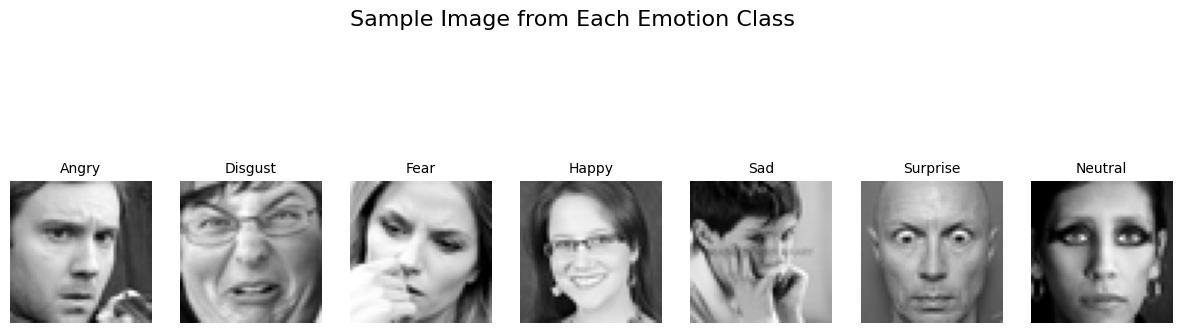

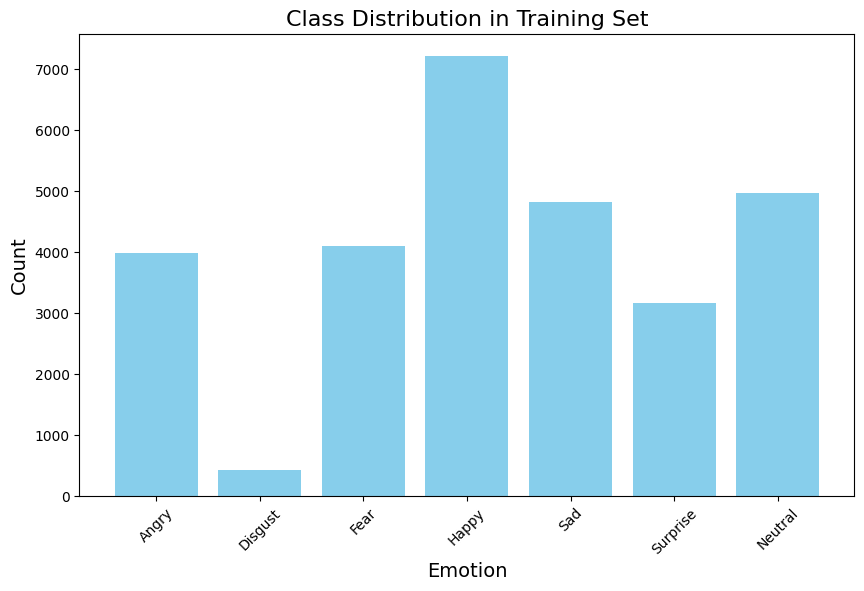

In [8]:
import matplotlib.pyplot as plt
from collections import Counter

# Define emotion names corresponding to class indices
emotion_names = [
    "Angry",      # Class 0
    "Disgust",    # Class 1
    "Fear",       # Class 2
    "Happy",      # Class 3
    "Sad",        # Class 4
    "Surprise",   # Class 5
    "Neutral"     # Class 6
]

# Extract class indices from the labels
y_train_classes = np.argmax(y_train, axis=1)

# Find one image per class
images_per_class = {}
for i, (image, label) in enumerate(zip(x_train, y_train_classes)):
    if label not in images_per_class:
        images_per_class[label] = image
    if len(images_per_class) == 7:  # Stop once we have one image for each class
        break

# Plot one image per class
plt.figure(figsize=(15, 5))
for emotion, image in images_per_class.items():
    plt.subplot(1, 7, emotion + 1)
    plt.imshow(image.squeeze(), cmap='gray')
    plt.title(emotion_names[emotion], fontsize=10)
    plt.axis('off')
plt.suptitle("Sample Image from Each Emotion Class", fontsize=16)
plt.show()

# Plot class distribution as a histogram
class_counts = Counter(y_train_classes)
plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.xlabel("Emotion", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.title("Class Distribution in Training Set", fontsize=16)
plt.xticks(range(7), emotion_names, rotation=45)  # Replace class indices with names
plt.show()


# Set the random seed for reproducibility

In [26]:
import tensorflow as tf
import random

# Set the random seed for reproducibility
seed = 90
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Set the seed for Keras (also affects model layers' initialization)
from tensorflow.keras import backend as K
K.set_floatx('float32')  # Ensures compatibility with float precision if needed

## Random search for ReLU CNN

In [ ]:
from keras_tuner.tuners import RandomSearch
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2

# Define the model building function with hyperparameters to be tuned
def build_model(hp):
    model = Sequential()

    # Layer 1: Convolution + BatchNorm + MaxPooling + Dropout
    model.add(Conv2D(
        filters=hp.Choice('filters_1', [48, 64, 128]),
        kernel_size=(hp.Choice('kernel_width_1', [3, 5]), hp.Choice('kernel_height_1', [3, 5])),
        activation='relu',
        input_shape=(48, 48, 1),
        kernel_regularizer=l2(hp.Choice('l2_1', [0.001, 0.01, 0.1])),
        padding='same'
    ))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(hp.Choice('dropout_1', [0.25, 0.35, 0.5])))

    # Layer 2: Convolution + BatchNorm + MaxPooling + Dropout
    model.add(Conv2D(
        filters=hp.Choice('filters_2', [64, 128, 256]),
        kernel_size=(hp.Choice('kernel_width_2', [3, 5]), hp.Choice('kernel_height_2', [3, 5])),
        activation='relu',
        kernel_regularizer=l2(hp.Choice('l2_2', [0.001, 0.01, 0.1])),
        padding='same'
    ))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(hp.Choice('dropout_2', [0.25, 0.35, 0.5])))

    # Layer 3: Convolution + BatchNorm + MaxPooling + Dropout
    model.add(Conv2D(
        filters=hp.Choice('filters_3', [128, 256]),
        kernel_size=(hp.Choice('kernel_width_3', [3, 5]), hp.Choice('kernel_height_3', [3, 5])),
        activation='relu',
        kernel_regularizer=l2(hp.Choice('l2_3', [0.001, 0.01, 0.1])),
        padding='same'
    ))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(hp.Choice('dropout_3', [0.25, 0.35, 0.5])))

    # Additional Layer 4: Convolution + BatchNorm + Dropout (Increased Depth)
    model.add(Conv2D(
        filters=hp.Choice('filters_4', [256, 512]),
        kernel_size=(hp.Choice('kernel_width_4', [3, 5]), hp.Choice('kernel_height_4', [3, 5])),
        activation='relu',
        kernel_regularizer=l2(hp.Choice('l2_4', [0.001, 0.01, 0.1])),
        padding='same'
    ))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Choice('dropout_4', [0.25, 0.35, 0.5])))

    # Flatten and add fully connected layers
    model.add(Flatten())
    model.add(Dense(
        units=hp.Choice('dense_units', [256, 512]),
        activation='relu',
        kernel_regularizer=l2(hp.Choice('l2_dense', [0.001, 0.01, 0.1]))
    ))
    model.add(Dropout(hp.Choice('dropout_dense', [0.25, 0.35, 0.5])))
    model.add(Dense(7, activation='softmax'))  # 7 output classes (emotions)

    # Compile the model
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

# Initialize Keras Tuner for Random Search
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',  # Optimize validation accuracy
    max_trials=40,  # Number of different hyperparameter combinations to try
    executions_per_trial=1,  # Number of trials for each hyperparameter combination
    directory='random_search_results',
    project_name='fer_cnn_tuning'
)

# Perform hyperparameter search
tuner.search(x_train, y_train, epochs=10, validation_data=(x_val, y_val))

# Retrieve the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best hyperparameters:")
for key, value in best_hps.values.items():
    print(f"{key}: {value}")


## Hyperband Tuning on ReLU model

In [ ]:
import tensorflow as tf
from kerastuner import Hyperband
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2

# Initialize the MirroredStrategy for multi-GPU support
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: ', strategy.num_replicas_in_sync)

def build_model(hp):
    with strategy.scope():  
        model = Sequential()

        # Layer 1: Convolution + BatchNorm + MaxPooling + Dropout
        model.add(Conv2D(
            filters=hp.Int('filters_1', min_value=32, max_value=128, step=32),
            kernel_size=hp.Choice('kernel_size_1', values=[3, 5]),
            activation='relu',
            input_shape=(48, 48, 1),
            kernel_regularizer=l2(0.001)
        ))
        model.add(BatchNormalization())
        model.add(MaxPooling2D((2, 2)))
        model.add(Dropout(hp.Float('dropout_1', min_value=0.2, max_value=0.5, step=0.1)))

        # Layer 2: Convolution + BatchNorm + MaxPooling + Dropout
        model.add(Conv2D(
            filters=hp.Int('filters_2', min_value=64, max_value=256, step=64),
            kernel_size=hp.Choice('kernel_size_2', values=[3, 5]),
            activation='relu',
            kernel_regularizer=l2(0.001)
        ))
        model.add(BatchNormalization())
        model.add(MaxPooling2D((2, 2)))
        model.add(Dropout(hp.Float('dropout_2', min_value=0.2, max_value=0.5, step=0.1)))

        # Layer 3: Convolution + BatchNorm + MaxPooling + Dropout
        model.add(Conv2D(
            filters=hp.Int('filters_3', min_value=128, max_value=512, step=128),
            kernel_size=hp.Choice('kernel_size_3', values=[3, 5]),
            activation='relu',
            kernel_regularizer=l2(0.01)
        ))
        model.add(BatchNormalization())
        model.add(MaxPooling2D((2, 2)))
        model.add(Dropout(hp.Float('dropout_3', min_value=0.2, max_value=0.5, step=0.1)))

        # Additional Layer 4: Convolution + BatchNorm + Dropout (Adjusted Kernel Size)
        model.add(Conv2D(
            filters=hp.Int('filters_4', min_value=128, max_value=512, step=128),
            kernel_size=hp.Choice('kernel_size_4', values=[3, 5]),
            activation='relu',
            kernel_regularizer=l2(0.01)
        ))
        model.add(BatchNormalization())
        model.add(Dropout(hp.Float('dropout_4', min_value=0.2, max_value=0.5, step=0.1)))

        # Flatten and add fully connected layers
        model.add(Flatten())
        model.add(Dense(
            units=hp.Int('dense_units', min_value=128, max_value=512, step=128),
            activation='relu',
            kernel_regularizer=l2(0.001)
        ))
        model.add(Dropout(hp.Float('dropout_5', min_value=0.2, max_value=0.5, step=0.1)))
        model.add(Dense(7, activation='softmax'))  # 7 output classes (emotions)

        # Compile the model
        model.compile(
            optimizer=hp.Choice('optimizer', values=['adam', 'sgd']),
            loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
            metrics=['accuracy']
        )
    
    return model
    
# Set up the Hyperband tuner
tuner = Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=10,
    hyperband_iterations=2,
    directory='my_dir',
    project_name='emotion_detection'
)

# Start the search process with multi-GPU support
tuner.search(x_train, y_train, epochs=10, validation_data=(x_val, y_val))

# Get the best model and hyperparameters
best_model = tuner.get_best_models(num_models=1)[0]
best_hp = tuner.oracle.get_best_trials()[0].hyperparameters
print("Best hyperparameters:", best_hp.values)


## Build the relu model

In [27]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2

# Final model after tuning
relu_model = Sequential()

# Layer 1: Convolution + BatchNorm + MaxPooling + Dropout
relu_model.add(Conv2D(48, (5, 5), activation='relu', input_shape=(48, 48, 1), kernel_regularizer=l2(0.001)))
relu_model.add(BatchNormalization())
relu_model.add(MaxPooling2D((2, 2)))
relu_model.add(Dropout(0.35))

# Layer 2: Convolution + BatchNorm + MaxPooling + Dropout
relu_model.add(Conv2D(256, (3, 3), activation='relu', kernel_regularizer=l2(0.001)))
relu_model.add(BatchNormalization())
relu_model.add(MaxPooling2D((2, 2)))
relu_model.add(Dropout(0.25))

# Layer 3: Convolution + BatchNorm + MaxPooling + Dropout
relu_model.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.01)))
relu_model.add(BatchNormalization())
relu_model.add(MaxPooling2D((2, 2)))
relu_model.add(Dropout(0.25))

# Layer 4: Convolution + BatchNorm + Dropout
relu_model.add(Conv2D(256, (3, 3), activation='relu', kernel_regularizer=l2(0.01)))
relu_model.add(BatchNormalization())
relu_model.add(Dropout(0.35))

# Flatten and add fully connected layers
relu_model.add(Flatten())
relu_model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.001)))
relu_model.add(Dropout(0.25))
relu_model.add(Dense(7, activation='softmax'))  # 7 output classes (7 emotions)

relu_model.compile(optimizer='adam',
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
              metrics=['accuracy'])

relu_model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 44, 44, 48)     │         1,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 44, 44, 48)     │           192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 22, 22, 48)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 22, 22, 48)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 20, 20, 256)    │       110,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 20, 20, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 10, 10, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 10, 10, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 8, 8, 128)      │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 2, 2, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 2, 2, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 969,255 (3.70 MB)

 Trainable params: 967,879 (3.69 MB)

 Non-trainable params: 1,376 (5.38 KB)

## Train the ReLU model. Also used ReduceLROnPlateau and early epoch stopping

In [28]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.5,          
                              patience=3,          
                              min_lr=1e-6)         

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = relu_model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=150,
    batch_size=128,
    callbacks=[reduce_lr, early_stopping],
    verbose=2
)

Epoch 1/150
225/225 - 22s - 100ms/step - accuracy: 0.3165 - loss: 4.7087 - val_accuracy: 0.2494 - val_loss: 3.6870 - learning_rate: 0.0010
Epoch 2/150
225/225 - 4s - 20ms/step - accuracy: 0.4103 - loss: 2.7291 - val_accuracy: 0.3199 - val_loss: 2.6027 - learning_rate: 0.0010
Epoch 3/150
225/225 - 4s - 20ms/step - accuracy: 0.4586 - loss: 2.2374 - val_accuracy: 0.4349 - val_loss: 2.2312 - learning_rate: 0.0010
Epoch 4/150
225/225 - 4s - 20ms/step - accuracy: 0.4831 - loss: 2.0792 - val_accuracy: 0.4806 - val_loss: 2.0616 - learning_rate: 0.0010
Epoch 5/150
225/225 - 4s - 20ms/step - accuracy: 0.4960 - loss: 1.9875 - val_accuracy: 0.4661 - val_loss: 2.0115 - learning_rate: 0.0010
Epoch 6/150
225/225 - 4s - 20ms/step - accuracy: 0.5068 - loss: 1.9275 - val_accuracy: 0.4968 - val_loss: 1.9483 - learning_rate: 0.0010
Epoch 7/150
225/225 - 5s - 20ms/step - accuracy: 0.5130 - loss: 1.8879 - val_accuracy: 0.5127 - val_loss: 1.8829 - learning_rate: 0.0010
Epoch 8/150
225/225 - 5s - 20ms/step - 

## Test Accuracy on ReLU model

In [29]:
# Evaluate the model on the test set
relu_model_test_loss, relu_model_test_accuracy = relu_model.evaluate(x_test, y_test, verbose=2)
print(f"Test Accuracy on ReLU architecture: {relu_model_test_accuracy * 100:.2f}%")


113/113 - 1s - 5ms/step - accuracy: 0.6651 - loss: 1.4015
Test Accuracy on ReLU architecture: 66.51%


## Plots to see Accuracy and Loss

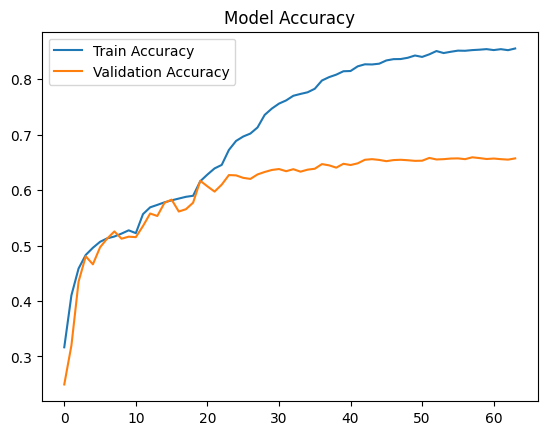

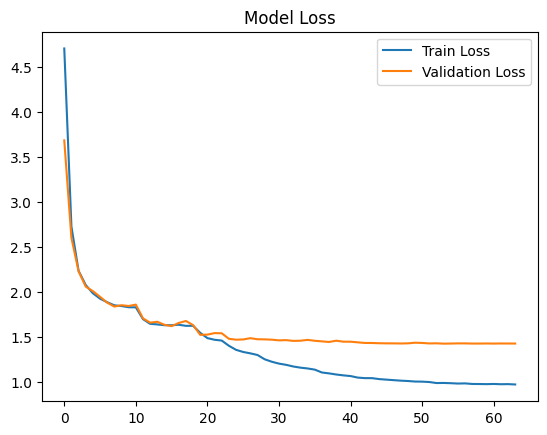

In [32]:
import matplotlib.pyplot as plt


# Plot training & validation accuracy values
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='best')
plt.title('Model Accuracy')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='best')
plt.title('Model Loss')
plt.show()


## Metrics and Confusion Matrix

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


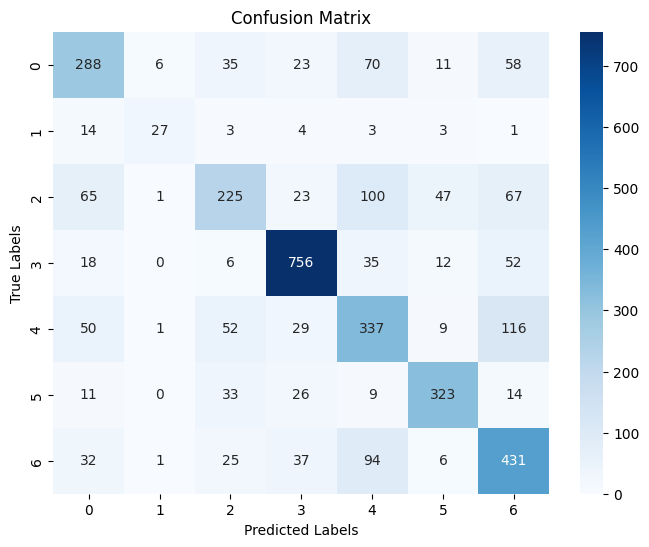

              precision    recall  f1-score   support

           0       0.60      0.59      0.59       491
           1       0.75      0.49      0.59        55
           2       0.59      0.43      0.50       528
           3       0.84      0.86      0.85       879
           4       0.52      0.57      0.54       594
           5       0.79      0.78      0.78       416
           6       0.58      0.69      0.63       626

    accuracy                           0.67      3589
   macro avg       0.67      0.63      0.64      3589
weighted avg       0.67      0.67      0.66      3589



In [33]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Assuming you have your test data (x_test, y_test) and the model is trained
y_pred = relu_model.predict(x_test)  # Predicting the labels for the test set
y_pred_classes = np.argmax(y_pred, axis=1)  # For multi-class classification (e.g., softmax output)
y_true = np.argmax(y_test, axis=1)  # If y_test is one-hot encoded

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Print classification report (precision, recall, F1-score)
print(classification_report(y_true, y_pred_classes))


## Use Hyperband to get the best parameters for LeakyReLU model

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import keras_tuner as kt

# Define MirroredStrategy for multi-GPU training
strategy = tf.distribute.MirroredStrategy()

print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

# Define a function to build the model using Keras tuning
def build_leakyrelu_model(hp):
    leakyrelu_model = Sequential()

    # Layer 1: Convolution + BatchNorm + MaxPooling + Dropout
    leakyrelu_model.add(Conv2D(48, (5, 5), kernel_regularizer=l2(hp.Float('l2_reg1', 1e-4, 1e-2, sampling='log')), 
                     input_shape=(48, 48, 1)))
    leakyrelu_model.add(LeakyReLU(negative_slope=hp.Float('negative_slope1', 0.001, 0.1, sampling='linear')))  
    leakyrelu_model.add(BatchNormalization())
    leakyrelu_model.add(MaxPooling2D((2, 2)))
    leakyrelu_model.add(Dropout(hp.Float('dropout1', 0.2, 0.5, sampling='linear')))  

    # Layer 2: Convolution + BatchNorm + MaxPooling + Dropout
    leakyrelu_model.add(Conv2D(256, (3, 3), kernel_regularizer=l2(hp.Float('l2_reg2', 1e-4, 1e-2, sampling='log'))))
    leakyrelu_model.add(LeakyReLU(negative_slope=hp.Float('negative_slope2', 0.001, 0.1, sampling='linear'))) 
    leakyrelu_model.add(BatchNormalization())
    leakyrelu_model.add(MaxPooling2D((2, 2)))
    leakyrelu_model.add(Dropout(hp.Float('dropout2', 0.2, 0.5, sampling='linear')))  

    # Layer 3: Convolution + BatchNorm + MaxPooling + Dropout
    leakyrelu_model.add(Conv2D(128, (3, 3), kernel_regularizer=l2(hp.Float('l2_reg3', 1e-4, 1e-2, sampling='log'))))
    leakyrelu_model.add(LeakyReLU(negative_slope=hp.Float('negative_slope3', 0.001, 0.1, sampling='linear'))) 
    leakyrelu_model.add(BatchNormalization())
    leakyrelu_model.add(MaxPooling2D((2, 2)))
    leakyrelu_model.add(Dropout(hp.Float('dropout3', 0.2, 0.5, sampling='linear')))  

    # Layer 4: Additional Convolution + BatchNorm + Dropout
    leakyrelu_model.add(Conv2D(256, (3, 3), kernel_regularizer=l2(hp.Float('l2_reg4', 1e-4, 1e-2, sampling='log'))))
    leakyrelu_model.add(LeakyReLU(negative_slope=hp.Float('negative_slope4', 0.001, 0.1, sampling='linear'))) 
    leakyrelu_model.add(BatchNormalization())
    leakyrelu_model.add(Dropout(hp.Float('dropout4', 0.2, 0.5, sampling='linear')))  

    # Flatten and add fully connected layers
    leakyrelu_model.add(Flatten())
    leakyrelu_model.add(Dense(256, kernel_regularizer=l2(hp.Float('l2_reg5', 1e-4, 1e-2, sampling='log'))))
    leakyrelu_model.add(LeakyReLU(negative_slope=hp.Float('negative_slope5', 0.001, 0.1, sampling='linear'))) 
    leakyrelu_model.add(Dropout(hp.Float('dropout5', 0.2, 0.5, sampling='linear')))  
    leakyrelu_model.add(Dense(7, activation='softmax'))  

    # Compile the model
    leakyrelu_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Float('learning_rate', 1e-5, 1e-2, sampling='log')),
        loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
        metrics=['accuracy']
    )

    return leakyrelu_model

# Initialize the tuner with RandomSearch
tuner = kt.RandomSearch(
    build_leakyrelu_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='my_dir',
    project_name='hyperparameter_tuning'
)

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

# Use MirroredStrategy for multi-GPU training
with strategy.scope():
    tuner.search(
        x_train, y_train,
        validation_data=(x_val, y_val),
        epochs=100, batch_size=64,
        callbacks=[early_stopping, lr_scheduler]
    )

## Building LeakyReLU model form the best hyperparametrs found

In [14]:
best_hyperparameters_leakyrelu = tuner.get_best_hyperparameters()[0]
leakyrelu_model = tuner.hypermodel.build(best_hyperparameters_leakyrelu)
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
history = leakyrelu_model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=400, batch_size=64, 
               callbacks=[early_stopping, lr_scheduler])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/400
449/449 ━━━━━━━━━━━━━━━━━━━━ 27s 34ms/step - accuracy: 0.2124 - loss: 5.5656 - val_accuracy: 0.2276 - val_loss: 4.7213 - learning_rate: 2.0109e-04
Epoch 2/400
449/449 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.3131 - loss: 4.4566 - val_accuracy: 0.4023 - val_loss: 3.8452 - learning_rate: 2.0109e-04
Epoch 3/400
449/449 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.3655 - loss: 3.8181 - val_accuracy: 0.4054 - val_loss: 3.3253 - learning_rate: 2.0109e-04
Epoch 4/400
449/449 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.3917 - loss: 3.2565 - val_accuracy: 0.4606 - val_loss: 2.8183 - learning_rate: 2.0109e-04
Epoch 5/400
449/449 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.4343 - loss: 2.8025 - val_accuracy: 0.4650 - val_loss: 2.5112 - learning_rate: 2.0109e-04
Epoch 6/400
449/449 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.4554 - loss: 2.4767 - val_accuracy: 0.4862 - val_loss: 2.2545 - learning_rate: 2.0109e-04
Epoch 7/400
449/449 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/st

## Testing the LeakyReLU model

In [15]:
# Evaluate the model on the test set
test_loss, test_accuracy = leakyrelu_model.evaluate(x_test, y_test, verbose=2)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


113/113 - 1s - 9ms/step - accuracy: 0.6676 - loss: 1.4581
Test Accuracy: 66.76%


## Plots to visualize Accuracy and Loss on LeakyReLU Model

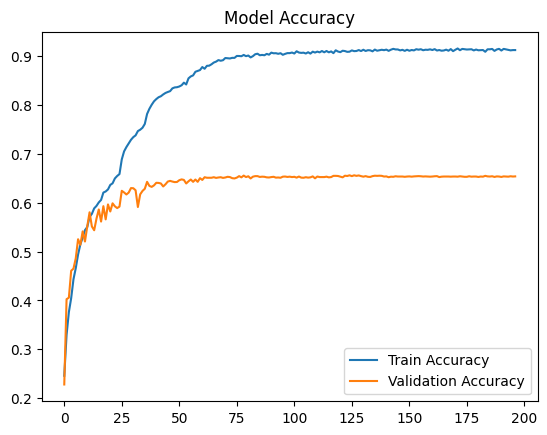

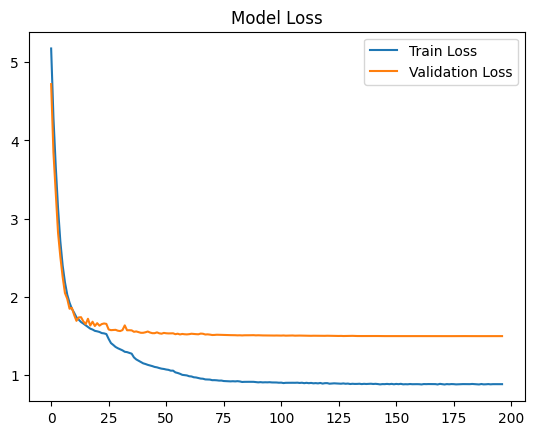

In [16]:
import matplotlib.pyplot as plt


# Plot training & validation accuracy values
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='best')
plt.title('Model Accuracy')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='best')
plt.title('Model Loss')
plt.show()


## Confusion matrix and metrics

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


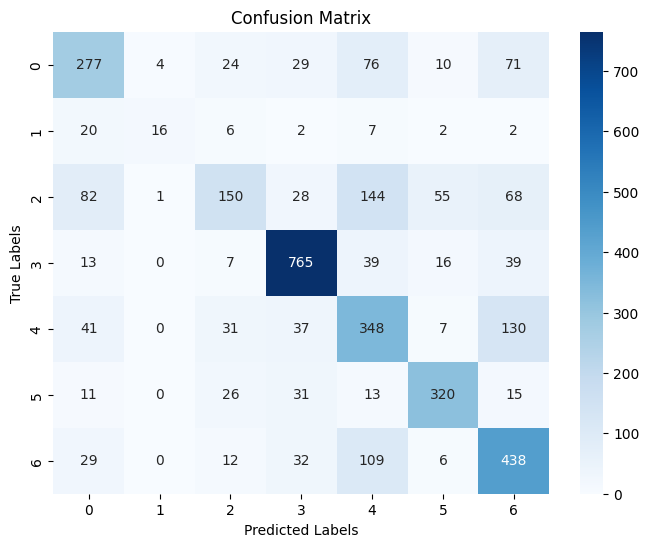

              precision    recall  f1-score   support

           0       0.59      0.56      0.57       491
           1       0.76      0.29      0.42        55
           2       0.59      0.28      0.38       528
           3       0.83      0.87      0.85       879
           4       0.47      0.59      0.52       594
           5       0.77      0.77      0.77       416
           6       0.57      0.70      0.63       626

    accuracy                           0.64      3589
   macro avg       0.65      0.58      0.59      3589
weighted avg       0.65      0.64      0.63      3589



In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Assuming you have your test data (x_test, y_test) and the model is trained
y_pred = relu_model.predict(x_test)  # Predicting the labels for the test set
y_pred_classes = np.argmax(y_pred, axis=1)  # For multi-class classification (e.g., softmax output)
y_true = np.argmax(y_test, axis=1)  # If y_test is one-hot encoded

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Print classification report (precision, recall, F1-score)
print(classification_report(y_true, y_pred_classes))


## Use Ensemble Stacking to build Meta Model using DecisionTreeClassifier with metrics


113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 67.96%

Classification Report:
              precision    recall  f1-score   support

       Angry       0.60      0.60      0.60       491
     Disgust       0.86      0.56      0.68        55
        Fear       0.55      0.54      0.55       528
       Happy       0.85      0.88      0.86       879
         Sad       0.58      0.50      0.54       594
    Surprise       0.79      0.78      0.79       416
     Neutral       0.60      0.70      0.65       626

    accuracy                           0.68      3589
   macro avg       0.69      0.65      0.67      3589
weighted avg       0.68      0.68      0.68      3589



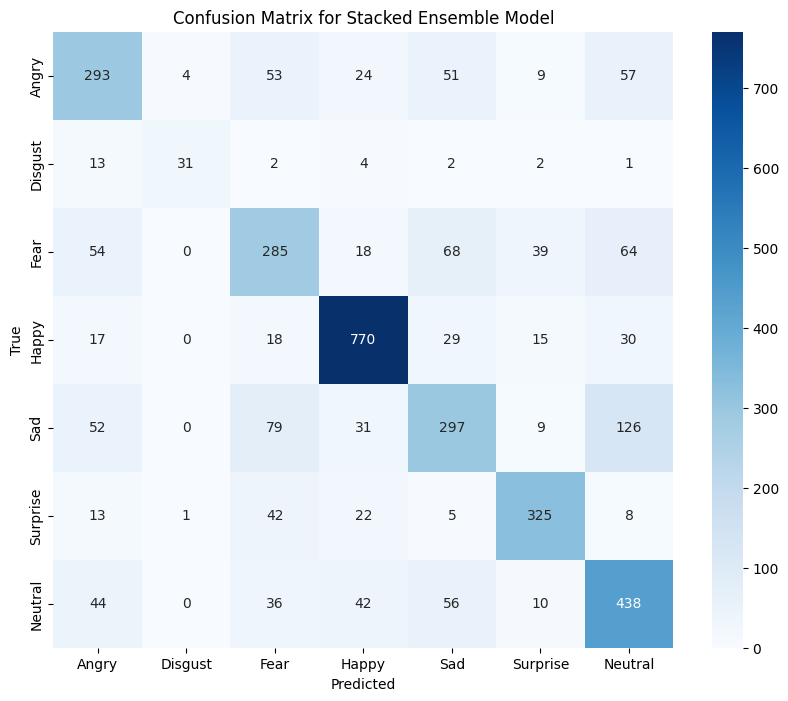

In [34]:
# relu and leakyrelu predictions
preds_model = np.argmax(relu_model.predict(x_test), axis=1)  
preds_best_model = np.argmax(leakyrelu_model.predict(x_test), axis=1)  

stacked_predictions = np.column_stack((preds_model, preds_best_model))

y_test_labels = np.argmax(y_test, axis=1)

# Decision tree as meta model
meta_model = DecisionTreeClassifier()
meta_model.fit(stacked_predictions, y_test_labels)  

# Stacking predictions
final_preds = meta_model.predict(stacked_predictions)

# Evaluation
accuracy = accuracy_score(y_test_labels, final_preds)
precision = precision_score(y_test_labels, final_preds, average='weighted')
recall = recall_score(y_test_labels, final_preds, average='weighted')
f1 = f1_score(y_test_labels, final_preds, average='weighted')

print(f"Accuracy: {accuracy * 100:.2f}%")

conf_matrix = confusion_matrix(y_test_labels, final_preds)

report = classification_report(y_test_labels, final_preds, target_names=emotion_names)
print("\nClassification Report:")
print(report)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=emotion_names, yticklabels=emotion_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix for Stacked Ensemble Model")
plt.show()


## Hyperparameter Tuning for Meta Model

In [35]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import numpy as np

# Define parameter ranges to explore
criterion_options = ['gini', 'entropy']
max_depth_options = [3, 5, 10, 15, None]
min_samples_split_options = [2, 5, 10, 20, 50]
min_samples_leaf_options = [1, 2, 4, 10, 20]
max_features_options = [None, 'sqrt', 'log2']

# Track the best model and accuracy
best_params = None
best_accuracy = 0
best_model = None

# Loop through all parameter combinations
for criterion in criterion_options:
    for max_depth in max_depth_options:
        for min_samples_split in min_samples_split_options:
            for min_samples_leaf in min_samples_leaf_options:
                for max_features in max_features_options:
                    model = DecisionTreeClassifier(
                        criterion=criterion,
                        max_depth=max_depth,
                        min_samples_split=min_samples_split,
                        min_samples_leaf=min_samples_leaf,
                        max_features=max_features,
                        random_state=45
                    )
                    
                    model.fit(stacked_predictions, y_test_labels)
                    
                    preds = model.predict(stacked_predictions)
                    accuracy = accuracy_score(y_test_labels, preds)
                    
                    if accuracy > best_accuracy:
                        best_accuracy = accuracy
                        best_params = {
                            'criterion': criterion,
                            'max_depth': max_depth,
                            'min_samples_split': min_samples_split,
                            'min_samples_leaf': min_samples_leaf,
                            'max_features': max_features
                        }
                        best_model = model

# Print the best parameters and accuracy
print("Best parameters:", best_params)
print("Best accuracy on test set:", best_accuracy)


Best parameters: {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None}
Best accuracy on test set: 0.6795764837001951


# Final Accuracy

In [36]:
print("Final Accuracy on test", best_accuracy)


Final Accuracy on test 0.6795764837001951


# Things we explored - 

- Class weights (Didnt help in increasing accuracy)
- Data Augmentation using SMOTE for Disgust class due to very limited data (Overall accuracy dropped)
- Noise Reduction
- Bagging meta model (Didnt imporve accuracy)
- Different meta model classifiers (Accuracy lower than decisiontree)

# Challenges

- GPU/RAM (Computational resources) couldnt train pretrained models easily
- Small dataset
- FER-2013 has considerable amount of noise
- Some Mislabelled data 

